In [1]:
#udo apt-get update
#sudo apt-get install libgl1
#sudo apt-get install poppler-utils tesseract-ocr libmagic-dev

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [15]:
#%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
#%pip install -Uq chromadb tiktoken
#%pip install -Uq langchain langchain-community langchain-openai langchain-groq
#%pip install -Uq python_dotenv

Note: you may need to restart the kernel to use updated packages.


In [1]:
from IPython.display import Markdown, display_pdf
from rich.markdown import Markdown as rich_Markdown

In [2]:
import os

os.environ["GROQ_API_KEY"] = "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"
os.environ["LANGCHAIN_API_KEY"] = "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"
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [3]:
file_path = "/workspaces/RAG_LangChain/data/DT_Golondrinas.pdf"

output_path = "/workspaces/RAG_LangChain/data/"
output_file_2 = "/workspaces/RAG_LangChain/data/chunks_docs/chunks_golondrinas_v2.json"

In [4]:
dict_pdfs = {
    "pdf1":{
        "file_path": file_path,
        "output_path": output_file_2,
    }
}

In [5]:
from unstructured.partition.pdf import partition_pdf
from unstructured.staging.base import dict_to_elements, elements_to_json
import json


ejecutar_pdf = False

def ejecutar_chunking_pdf(dict_pdfs,ejecutar_pdf=False):
    
    if ejecutar_pdf:
        output_path = "/workspaces/RAG_LangChain/data/"

        chunks = partition_pdf(
            filename=dict_pdfs['pdf1']['file_path'],
            infer_table_structure=True,            # extract tables
            strategy="hi_res",                     # mandatory to infer tables

            extract_image_block_types=["Image"],   # Add 'Table' to list to extract image of tables
            image_output_dir_path=output_path,   # if None, images and tables will saved in base64

            extract_image_block_to_payload=True,   # if true, will extract base64 for API usage

            chunking_strategy="by_title",          # or 'basic'
            max_characters=10000,                  # defaults to 500
            combine_text_under_n_chars=2000,       # defaults to 0
            new_after_n_chars=6000,

            # extract_images_in_pdf=True,          # deprecated
        )

        json_data = elements_to_json(chunks)

        
        with open(dict_pdfs['pdf1']['output_path'], 'w', encoding='utf-8') as f:
            f.write(json_data)

    else:
        with open(output_file_2, 'r', encoding='utf-8') as f:
            json_data = f.read()

        # Convertir la cadena JSON en una lista de diccionarios
        element_dicts = json.loads(json_data)

        # Verificar que element_dicts es una lista de diccionarios
        if isinstance(element_dicts, list) and all(isinstance(d, dict) for d in element_dicts):
            # Convertir los diccionarios en elementos utilizando dict_to_elements
            chunks = dict_to_elements(element_dicts)
        else:
            raise ValueError("El contenido del archivo JSON no es una lista de diccionarios válida.")

    return chunks

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
chunks = ejecutar_chunking_pdf(dict_pdfs,ejecutar_pdf=False)

In [7]:
import utils_rag

tables, texts, images_b64 = utils_rag.data_general(chunks)

In [10]:
#utils_rag.display_base64_image(images_b64[0])

In [65]:
chunks[0].to_dict()['metadata']['filename']

'DT_Golondrinas.pdf'

In [66]:
def extract_text_with_page_mapping(chunks):
    """
    Extrae únicamente el texto de los chunks y mapea cada fragmento al número de página correspondiente.

    Args:
        chunks: Lista de elementos generados por ejecutar_chunking_pdf.

    Returns:
        List[Dict]: Lista de diccionarios con 'text' y 'page_number'.
    """
    text_chunks = []
    tables_html_chunks = []
    images_b64_chunks = []
    if len(chunks) > 0:
        file_name_pdf = chunks[0].to_dict()['metadata']['filename']


    for chunk in chunks:
        # Verificar si el chunk es un CompositeElement
        text_chunk = ''
        if "CompositeElement" in str(type(chunk)):
            for elem in chunk.metadata.orig_elements:
                page_numbers = utils_rag.extract_page_numbers_from_chunks(chunk)
                # Ignorar elementos de tipo Table e Image
                if "Table" not in str(type(elem)) and "Image" not in str(type(elem)):
                    texto = elem.text.strip()
                    text_chunk += texto + '\n'
                elif "Table" in str(type(elem)):
                    # Si el elemento es una tabla o una imagen, extraer los números de página
                    #tables_html_chunks.append(elem.metadata.text_as_html)
                    tables_html_chunks.append({
                            'text_html': elem.metadata.text_as_html,
                            'page_number': page_numbers,
                            'filename': file_name_pdf

                        })
                elif "Image" in str(type(elem)):

                    images_b64_chunks.append(
                        {
                            'images_b64': elem.metadata.image_base64,
                            'page_number': page_numbers,
                            'filename': file_name_pdf
                        }
                        )

            text_chunks.append({
                            'text': text_chunk,
                            'page_number': page_numbers,
                            'filename': file_name_pdf
                        })
            
        else:
            # Si el chunk no es CompositeElement, asumir que es un texto simple
            texto = chunk.text.strip()
            if texto:
                numero_pagina = chunk.metadata.page_number
                text_chunks.append({
                    'text': texto,
                    'page_number': numero_pagina
                })

    return text_chunks, tables_html_chunks, images_b64_chunks

In [67]:
ejemplo = [chunks[7],chunks[20]]
text_chunks, tables_html_chunks, images_b64_chunks = extract_text_with_page_mapping(ejemplo)

In [68]:
text_chunks

[{'text': 'para proyectos que ingresan al SEIA4 .\nRecientemente se identificó una nueva especie para la zona central, la Oceanites barrosi, que nidifica en zonas precordilleranas sobre los 1 .400 msnm, y que podría verse afecta a los mismos impactos y medidas del presente documento (Norambuena et al ., 2024) . Respecto de esta especie aún no existen suficientes datos como para poder incluirla dentro de este\ndocumento técnico .\nA continuación, se presentan los aspectos más relevantes de las cuatro especies .\nD . S . N°1/23 . Norma de Emisión de Luminosidad Artificial Generada por Alumbrados de Exteriores, elaborada a partir de la revisión del Decreto Supremo Nº43, de 2012, del Ministerio del Medio Ambiente .\n4\nIntroduccién\nIntroducción\nzm\n10\nCRITERIO DE EVALUACION EN EL SEIA\nTabla 1. Hydrobates markhami (golondrina de mar negra)\n',
  'page_number': {11, 12},
  'filename': 'DT_Golondrinas.pdf'},
 {'text': 'Figura 3. Gráfica de alturas de vuelo y porcentaje de aves\nAltura de 

In [69]:
tables_html_chunks

[{'text_html': '<table><tbody><tr><td>Distribuci6n</td><td>Se encuentra entre las aguas del extremo norte de Chile, colindando con Pert y hasta la Region de Atacama, alcanzando raramente las regiones de Coquimbo y Valparaiso. Nidifica en extensas areas de Arica y Parinacota, Tarapaca y Antofagasta, que en su conjunto albergan al 96% de la poblacion global conocida de la especie.</td></tr><tr><td rowspan="2">Sitios en los que se conoce su nidificacion</td><td>Region de Arica y Parinacota: Pampas Chufo, La Higuera, Chaca y Camarones.</td></tr><tr><td>Region de Tarapaca: Pampa Tana/Chiza, Salar de Quiujia, Jarza, Caleta Buena (Pampa Perdiz), El Carmen norte, Pampa Hermosa, Salar Grande y Loa (sector norte). Region de Antofagasta: Rio Loa y Salar de Navidad.</td></tr><tr><td>Caracteristicas de los sitios reproductivos</td><td>Los nidos se ubican en sectores con afloramientos de sal que ofrecen fisuras y cavidades naturales, pudiendo estar cubiertas en forma variable por arena. Se han regis

In [70]:
images_b64_chunks

[{'images_b64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAA/AIsDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+sPVPGHh7RZGiv8AVbeOVeGjUl3X6qoJFZ/xH1i60Xwbcz2bmOeV1hWReqBupHvgEfjXn3gj4ZWviLRY9W1K+nSKcsI4rfAb5WKkliD3B4x+Nawpx5eaT0OStXmqnsqSu9zv/wDhZ/g7/oMf+S03/wA

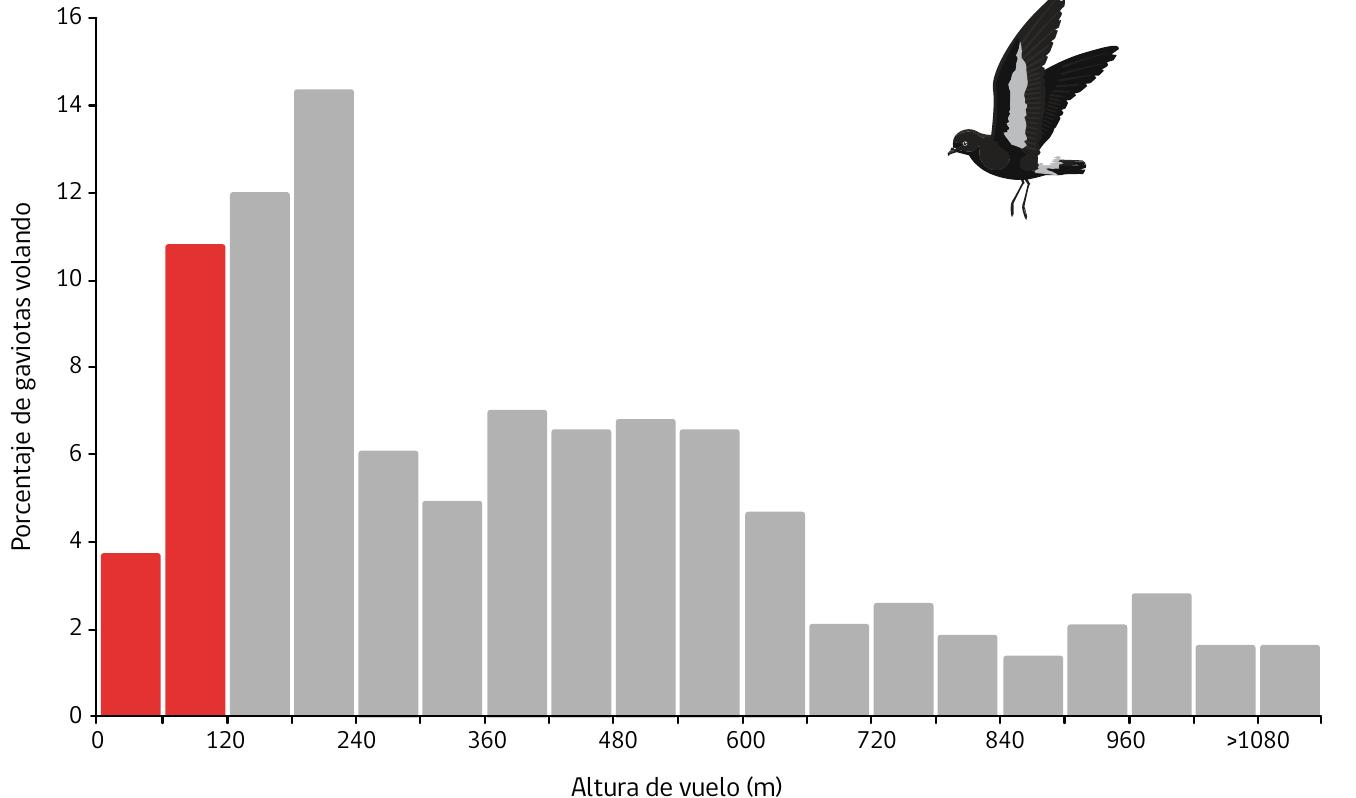

In [71]:
utils_rag.display_base64_image(images_b64_chunks[1]['images_b64'])

In [35]:

from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt_text = """
Eres un asistente cuya tarea es resumir tablas y texto.
Da un resumen conciso de la tabla o el texto.

Responde solo con el resumen, sin comentarios adicionales.
No comiences tu mensaje diciendo "Aquí hay un resumen" ni nada por el estilo.
Solo da el resumen tal como está.

Fragmento de tabla o texto: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.2, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()


In [42]:
def summarize_text_chunks(text_chunks,text):
    """
    Aplica la cadena de resumen a cada fragmento de texto.
    
    Args:
        text_chunks (List[Dict]): Lista de diccionarios con 'text' y 'page_number'.
    
    Returns:
        List[Dict]: Lista de diccionarios con 'summary' y 'page_number'.
    """
    summarized_chunks = []
    
    for chunk in text_chunks:
        texto = chunk[text]
        paginas = chunk['page_number']
        
        # Crear el contexto para el prompt, incluyendo las páginas
        prompt_input = f"{texto}"
        
        # Aplicar la cadena de resumen
        resumen = summarize_chain.invoke(prompt_input)
        
        summarized_chunks.append({
            'summary': resumen,
            'page_number': paginas
        })
    
    return summarized_chunks

# Aplicar la función de resumen
summaries = summarize_text_chunks(text_chunks,'text')

In [43]:
summaries

[{'summary': 'Se identificó una nueva especie, Oceanites barrosi, que nidifica en zonas precordilleranas sobre 1.400 msnm, pero no hay suficientes datos para incluirla en el documento. Se presentan los aspectos relevantes de las cuatro especies: Hydrobates markhami, D. S. N°1/23, Norma de Emisión de Luminosidad Artificial y CRITERIO DE EVALUACION EN EL SEIA.',
  'page_number': {11, 12}},
 {'summary': 'Se utiliza un sistema de radar para determinar distancia, desplazamiento y altura de vuelo de golondrinas de mar. La metodología requiere al menos dos especialistas y registros diarios para descartar vuelos en diferentes horarios. Se pueden determinar horarios de desplazamiento, altura y dirección de vuelo, lo que permite evaluar el riesgo de colisión con aerogeneradores y LTE.',
  'page_number': {28, 29}}]

In [45]:
summaries_tables = summarize_text_chunks(tables_html_chunks,'text_html')

In [46]:
summaries_tables

[{'summary': 'La especie se encuentra entre las aguas del extremo norte de Chile, principalmente en las regiones de Arica y Parinacota, Tarapaca y Antofagasta. Se estima que su población oscila entre 700.000 y 1.600.000 individuos, aunque solo 115.000 a 116.000 individuos se encuentran en colonias reproductivas. La reproducción ocurre en diferentes periodos dependiendo de la región, con un peak de salida de volantones en noviembre-diciembre en algunas áreas y marzo-abril en otras.',
  'page_number': {11, 12}}]

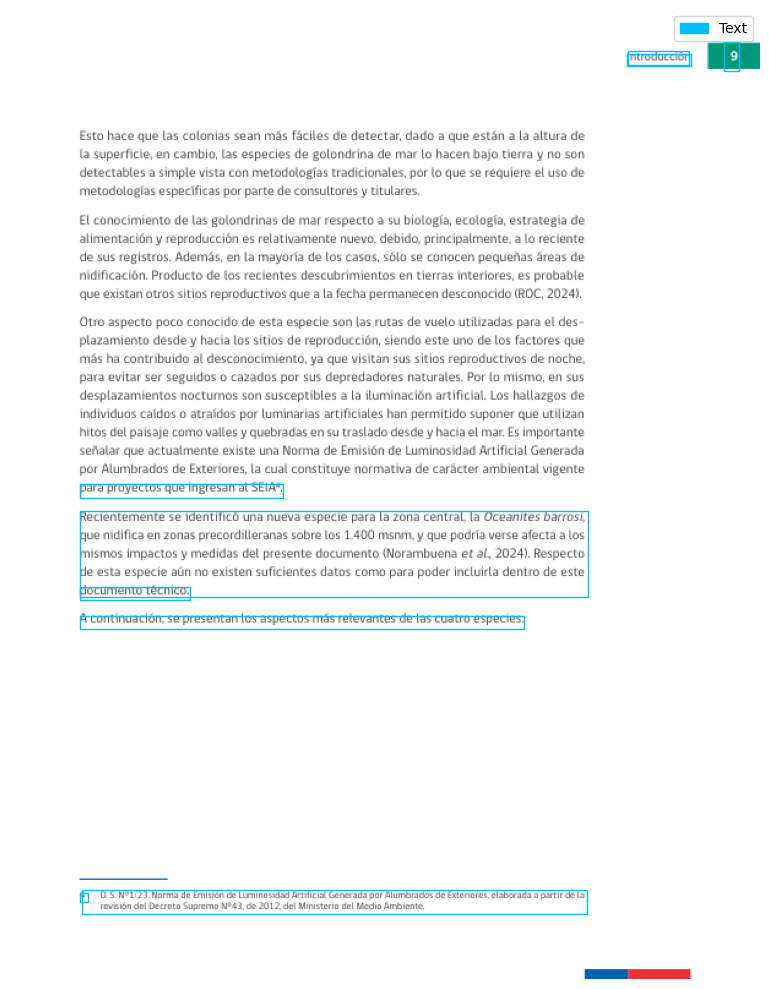

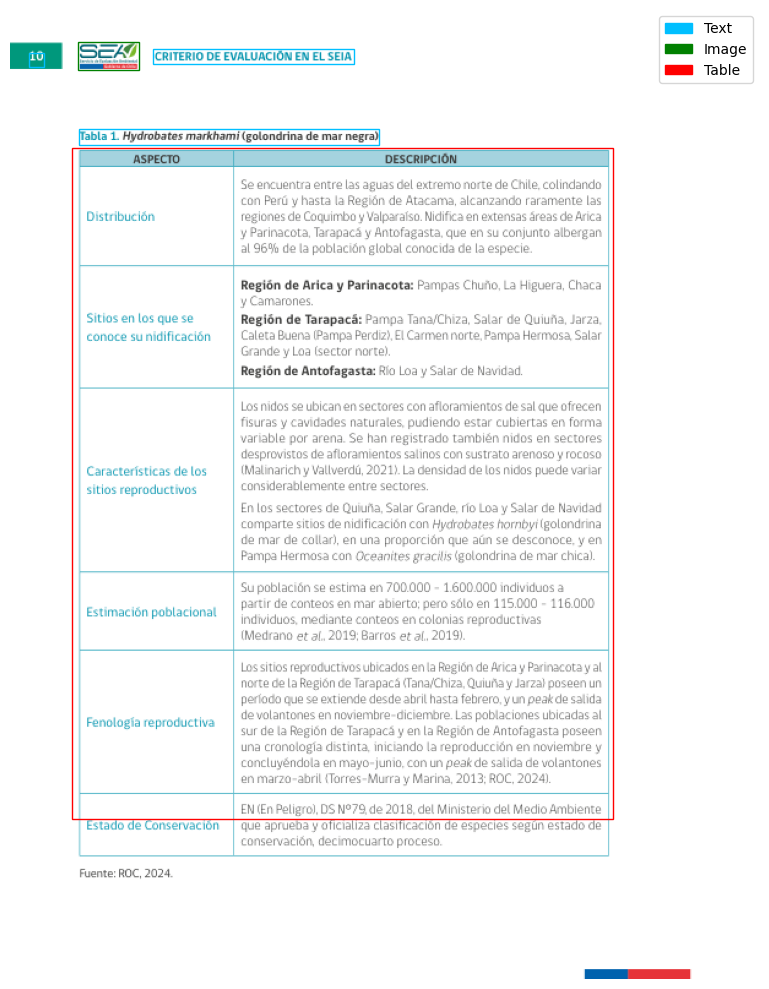

In [72]:
utils_rag.display_chunk_pages(chunks[7],file_path)

In [89]:
display(rich_Markdown(text_chunk)) 

para proyectos que ingresan al SEIA4 . Recientemente se identificó una nueva especie para la zona central, la      
Oceanites barrosi, que nidifica en zonas precordilleranas sobre los 1 .400 msnm, y que podría verse afecta a los   
mismos impactos y medidas del presente documento (Norambuena et al ., 2024) . Respecto de esta especie aún no      
existen suficientes datos como para poder incluirla dentro de este documento técnico . A continuación, se presentan
los aspectos más relevantes de las cuatro especies . D . S . N°1/23 . Norma de Emisión de Luminosidad Artificial   
Generada por Alumbrados de Exteriores, elaborada a partir de la revisión del Decreto Supremo Nº43, de 2012, del    
Ministerio del Medio Ambiente . 4 Introduccién Introducción zm 10 @ CRITERIO DE EVALUACION EN EL SEIA Tabla 1.     
Hydrobates markhami (golondrina de mar negra)

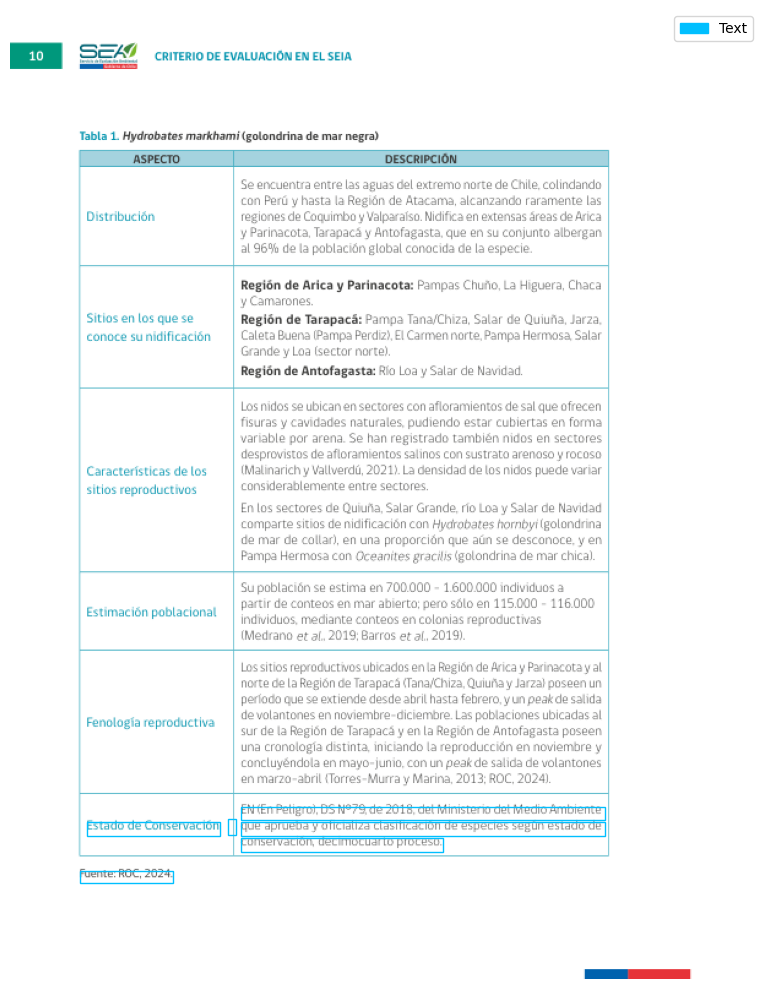

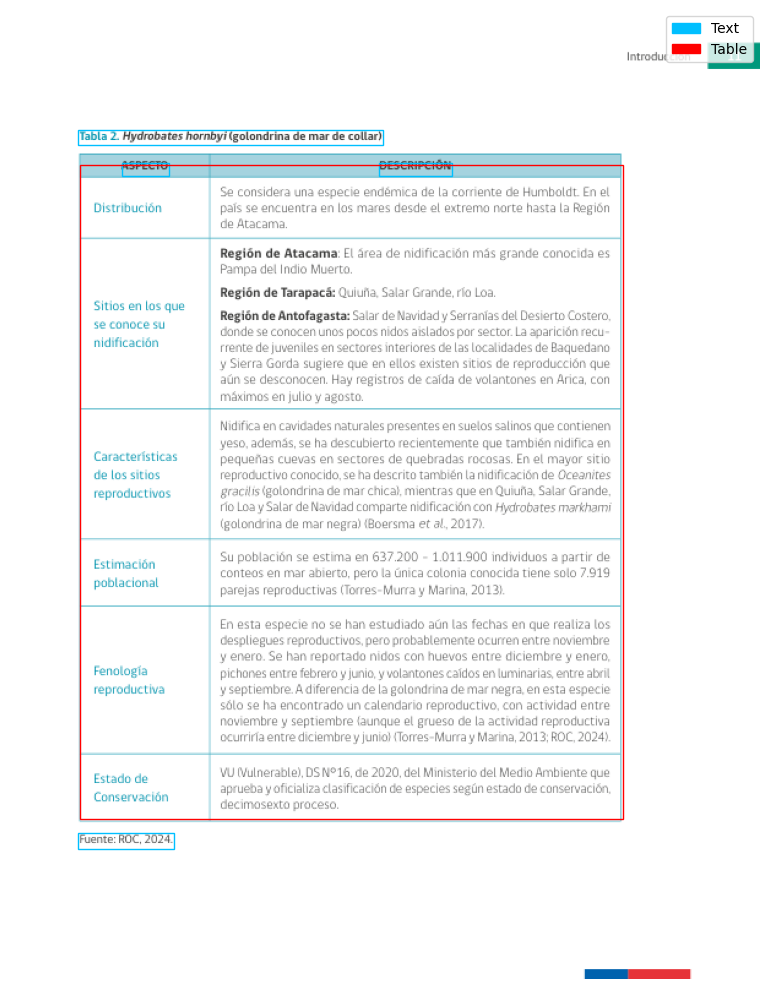

In [102]:
utils_rag.display_chunk_pages(chunks[8],file_path)

In [91]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [92]:

from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt_text = """
Eres un asistente cuya tarea es resumir tablas y texto.
Da un resumen conciso de la tabla o el texto.

Responde solo con el resumen, sin comentarios adicionales.
No comiences tu mensaje diciendo "Aquí hay un resumen" ni nada por el estilo.
Solo da el resumen tal como está.

Fragmento de tabla o texto: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()
summarize_chain_2 = prompt | model | StrOutputParser()

In [93]:
table_summaries = summarize_chain.batch(tables_html_chunk, {"max_concurrency": 3})

In [99]:
table_summaries

['La distribución de la especie se encuentra en el extremo norte de Chile, principalmente en las regiones de Arica y Parinacota, Tarapaca y Antofagasta, con una población estimada de 700.000 a 1.600.000 individuos. Nidifican en áreas de sal y rocas, compartiendo sitios con otras especies de aves marinas. La reproducción ocurre de abril a febrero en el norte y de noviembre a mayo en el sur, con picos de salida de volantones en noviembre-diciembre y marzo-abril.']

In [95]:

display(rich_Markdown(table_summaries[0]))

La distribución de la especie se encuentra en el extremo norte de Chile, principalmente en las regiones de Arica y 
Parinacota, Tarapaca y Antofagasta, con una población estimada de 700.000 a 1.600.000 individuos. Nidifican en     
áreas de sal y rocas, compartiendo sitios con otras especies de aves marinas. La reproducción ocurre de abril a    
febrero en el norte y de noviembre a mayo en el sur, con picos de salida de volantones en noviembre-diciembre y    
marzo-abril.

In [96]:
resumen = summarize_chain_2.invoke(text_chunk)

In [98]:
display(rich_Markdown(resumen))

Se identificó una nueva especie (Oceanites barrosi) en la zona central, pero aún no hay suficientes datos para     
incluirla en el documento. Se presentan los aspectos relevantes de las cuatro especies de aves marinas: Hydrobates 
markhami, Fulmarus glacialoides, Fulmarus glacialis y Diomedea exulans.

In [36]:
from IPython.display import Markdown, display_pdf
from rich.markdown import Markdown as rich_Markdown

display(rich_Markdown(texts_1[0].to_dict()['text'])) 

REPÚBLICA DE CHILE SERVICIO DE EVALUACIÓN AMBIENTAL DIRECCIÓN EJECUTIVA                                            

SE PRONUNCIA SOBRE OBSERVANCIA DE CRITERIO DE EVALUACIÓN EN EL GOLONDRINAS DE MAR EN EL MARCO DEL SEIA             

LA                                                                                                                 

SEIA:                                                                                                              

RESOLUCIÓN EXENTA                                                                                                  

SANTIAGO,                                                                                                          

VISTOS:                                                                                                            

Lo dispuesto en la Ley Nº19.300, sobre Bases Generales del Medio Ambiente (en adelante, “Ley N°19.300”); en el     
Decreto Supremo Nº40, de 2012, del Ministerio del Medio Ambiente, que establece el Reglamento del Sistema de       
Evaluación de Impacto Ambiental (en adelante, “Reglamento del SEIA”); en el Decreto con Fuerza de Ley N°1/19.653,  
que Fija el Texto Refundido, Coordinado y Sistematizado de la Ley Nº18.575, Orgánica Constitucional de Bases       
Generales de la Administración del Estado; en la Ley Nº19.880, sobre Bases de los Procedimientos Administrativos   
que rigen los Actos de los Órganos de la Administración del Estado; en el Decreto N°40, de fecha 06 de abril de    
2022, del Ministerio del Medio Ambiente, que nombra Directora Ejecutiva del Servicio de Evaluación Ambiental; el   
Oficio Ordinario N° 202499102679, de fecha 30 de julio 2024, de la Directora Ejecutiva del SEA, que deja sin efecto
y complementa instrucciones sobre la aplicabilidad de las guías y criterios de evaluación publicados por la        
Dirección Ejecutiva del Servicio de Evaluación Ambiental y en la Resolución Nº07 del 26 de marzo del año 2019 de la
Contraloría General de la República, que Fija Normas sobre Exención del Trámite de Toma de Razón.                  

CONSIDERANDO:                                                                                                      

 1 Que, la letra d) del artículo 81 de la Ley N°19.300 establece que corresponderá al Servicio de Evaluación       
   Ambiental “uniformar los criterios, requisitos, condiciones, antecedentes, certificados, trámites, exigencias   
   técnicas y procedimientos de carácter ambiental que establezcan los ministerios y demás organismos del Estado   
   competentes, mediante el establecimiento, entre otros, de guías trámite”.                                       
 2 Que, el inciso 2° del artículo 4° del Reglamento del SEIA, dispone que el “Servicio podrá, de conformidad a lo  
   señalado en el artículo 81 letra d) de la Ley, uniformar los criterios o exigencias técnicas asociadas a los    
   efectos, características o circunstancias contempladas en el artículo 11 de la Ley, los que deberán ser         
   observados para los efectos del presente Título” (Título II del Reglamento del SEIA).                           
 3 Que, en el ejercicio de las facultades precedentemente señaladas, el Servicio ha elaborado la “Criterio de      
   evaluación en el SEIA: golondrinas de mar en el marco del SEIA”.                                                

El objetivo de esta publicación es entregar directrices técnicas a los titulares, consultoras/es, evaluadores/es y 
la ciudadanía, sobre cómo abordar la presencia de golondrinas de mar en el área de influencia de un proyecto. En   
este documento se incluyen metodologías ajustadas para estas especies; impactos potenciales; medidas y compromisos 
ambientales voluntarios y forma de elaborar el plan de seguimiento de las especies.                                

 4 Que, de acuerdo a lo señalado en el Oficio Ordinario N° 202499102679, de fecha 30 de julio 2024, de la Directora
   Ejecutiva del SEA, que deja sin efecto y c

In [29]:
texts_1[1].metadata.orig_elements[1].to_dict() 

{'type': 'ListItem',
 'element_id': 'f155a2ab-fd86-4513-ad99-07174c8463b5',
 'text': '1. Tener presente la observancia del documento singularizado en el Considerando N°3 de la presente resolución.',
 'metadata': {'coordinates': {'points': ((227.9, 757.9),
    (227.9, 833.3),
    (1472.9, 833.3),
    (1472.9, 757.9)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2800},
  'detection_class_prob': 0.89497,
  'filetype': 'PPM',
  'languages': ['eng'],
  'last_modified': '2024-12-31T14:37:49',
  'page_number': 2}}

In [31]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01jbhqxy8rf2zr18ceynbqz272` on tokens per minute (TPM): Limit 20000, Used 20422, Requested 983. Please try again in 4.216999999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

In [ ]:
import os
from typing import List, Dict, Any



# Borrar

In [17]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))


def data_general(chunks):
    # separate tables from texts
    tables = []
    texts = []
    images_b64 = []
    for chunk in chunks:
        if "Table" in str(type(chunk)):
            tables.append(chunk)

        if "CompositeElement" in str(type((chunk))):
            texts.append(chunk)
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    
    return tables, texts, images_b64



In [15]:
tables, texts, images_b64 = data_general(chunks)

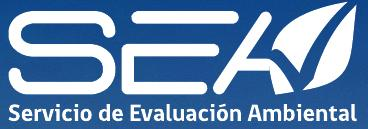

In [18]:
display_base64_image(images_b64[0])

In [5]:
import json


#output_path = "/workspaces/RAG_LangChain/data/chunks_docs"
output_file = "/workspaces/RAG_LangChain/data/chunks_docs/chunks_golondrinas.json"



# Función para serializar los objetos de metadatos que no son serializables por defecto
def metadata_serializer(obj):
    if hasattr(obj, 'to_dict'):
        return obj.to_dict()
    raise TypeError(f"Object of type {obj.__class__.__name__} is not JSON serializable")

# Preparar los datos para el archivo JSON
data_to_save = []
for chunk in chunks:
    chunk_data = {
        "type": chunk.__class__.__name__,
        "text": chunk.text,
        "metadata": chunk.metadata.to_dict(),
    }
    data_to_save.append(chunk_data)

# Guardar los datos en un archivo JSON
output_file = "/workspaces/RAG_LangChain/data/chunks_docs/chunks_golondrinas.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(data_to_save, f, ensure_ascii=False, indent=4, default=metadata_serializer)


In [11]:
from unstructured.staging.base import dict_to_elements, elements_to_json

json_data = elements_to_json(chunks)

    

In [13]:
output_file_2 = "/workspaces/RAG_LangChain/data/chunks_docs/chunks_golondrinas_v2.json"
with open(output_file_2, 'w', encoding='utf-8') as f:
    f.write(json_data)

In [8]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

In [10]:
chunks

In [9]:
chunks[0]

In [8]:
chunks[0].metadata.orig_elements

In [9]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

#display_base64_image(images[10])

In [25]:
import fitz
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image

def plot_pdf_with_boxes(pdf_page, segments) :
  pix = pdf_page.get_pixmap()
  pil_image = Image.frombytes ("RGB", [pix.width, pix.height], pix.samples)
  fig, ax = plt.subplots(1, figsize=(10, 10))
  ax. imshow (pil_image)
  categories = set()
  category_to_color = {
      'Title': 'blue',
      'Image': 'green',
      'Table': 'red',
  }
  for segment in segments:
    points = segment ["coordinates"] ["points"]
    layout_width = segment ["coordinates"] ["layout_width"]
    layout_height = segment ["coordinates" ] ["layout_height"]
    scaled_points = [
        (x * pix.width / layout_width, y * pix.height / layout_height)
        for x, y in points
        ]
    box_color = category_to_color.get(segment["category"], "deepskyblue")
    categories.add(segment["category"])
    rect = patches.Polygon(scaled_points, linewidth=1, edgecolor=box_color, facecolor="none")
    ax.add_patch(rect)

  # Make legend
  legend_handles = [patches.Patch(color="deepskyblue", label="Text" )]
  for category in ["Title", "Image", "Table"]:
    if category in categories:
      legend_handles.append(
          patches.Patch(color=category_to_color[category], label=category)
      )
  ax.axis("off")
  ax.legend(handles=legend_handles, loc="upper right")
  plt.tight_layout()
  plt.show()

def render_page(doc_list: list, page_number: int, print_text=True) -> None:

  pdf_page = fitz.open (file_path). load_page (page_number - 1)
  page_docs = [
      doc for doc in doc_list if doc.metadata.get ("page_number") == page_number
  ]
  segments = [doc.metadata for doc in page_docs]
  plot_pdf_with_boxes(pdf_page, segments)
  if print_text:
    for doc in page_docs:
      print(f"{doc. page_content}\n" )

In [26]:
for i, chunk in enumerate(chunks):

  if "CompositeElement" in str(type(chunk)):
    print("\n\nChunk", i)
    for doc in chunk.metadata.orig_elements:
      print(doc.to_dict()["type"], doc.metadata.page_number)



Chunk 0
NarrativeText 1
Table 1
Title 1
UncategorizedText 1
NarrativeText 1
Title 1
Title 1
NarrativeText 1
Title 1
ListItem 1
ListItem 1
ListItem 1
NarrativeText 1
ListItem 2


Chunk 1
Title 2
ListItem 2
ListItem 2
Title 2
Title 2
NarrativeText 2
Title 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
Title 2
ListItem 2
ListItem 2
ListItem 2
ListItem 2
NarrativeText 3
Image 3
NarrativeText 3
Title 3
Image 3
Header 4
Image 4
Header 4
UncategorizedText 4
NarrativeText 4
Title 4
NarrativeText 4
Title 4
NarrativeText 4
NarrativeText 4


Chunk 2
Title 4
Title 5
Table 5
UncategorizedText 5
UncategorizedText 5
Footer 6
Image 6
Image 6


Chunk 3
Title 7
NarrativeText 7
NarrativeText 7
NarrativeText 7


Chunk 4
Title 7
NarrativeText 7
Footer 7
UncategorizedText 7
UncategorizedText 7
UncategorizedText 8
Image 8
Header 8
NarrativeText 8
NarrativeText 8
NarrativeText 8
NarrativeText 8
NarrativeText 8
Title 8


Chunk 5
Title 9
NarrativeText 9
NarrativeText 9
Narrativ

In [27]:
chunks[1].metadata.orig_elements[0].to_dict()

{'type': 'Title',
 'element_id': 'daa45856-1cdf-406b-98ca-e0f62bcc7ed1',
 'text': 'RESUELVO:',
 'metadata': {'detection_class_prob': 0.8482891321182251,
  'coordinates': {'points': ((234.69395446777344, 680.451171875),
    (234.69395446777344, 719.3567504882812),
    (437.3888888888889, 719.3567504882812),
    (437.3888888888889, 680.451171875)),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2800},
  'last_modified': '2024-12-31T14:37:49',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 2}}

In [28]:
from langchain_core.documents import Document

def extract_page_numbers_from_chunks(chunk):
  
  elements = chunk.metadata.orig_elements
  page_numbers = set()

  for element in elements:
    page_numbers.add(element.metadata.page_number)
  
  return page_numbers

def display_chunk_pages(chunk):
  
  
  page_numbers = extract_page_numbers_from_chunks(chunk)
  
  docs = []

  for element in chunk.metadata.orig_elements:
    metadata = element.metadata.to_dict()
    if "Table" in str(type(element)):
      metadata["category"] = "Table"
    elif "Image" in str(type(element)):
      metadata["category"] = "Image"
    else:
      metadata["category"] = "Text"

    metadata["page_number"] = element.metadata.page_number

    docs.append(Document(page_content=element.text, metadata=metadata))

  for page_number in page_numbers:
    render_page(docs, page_number, False)


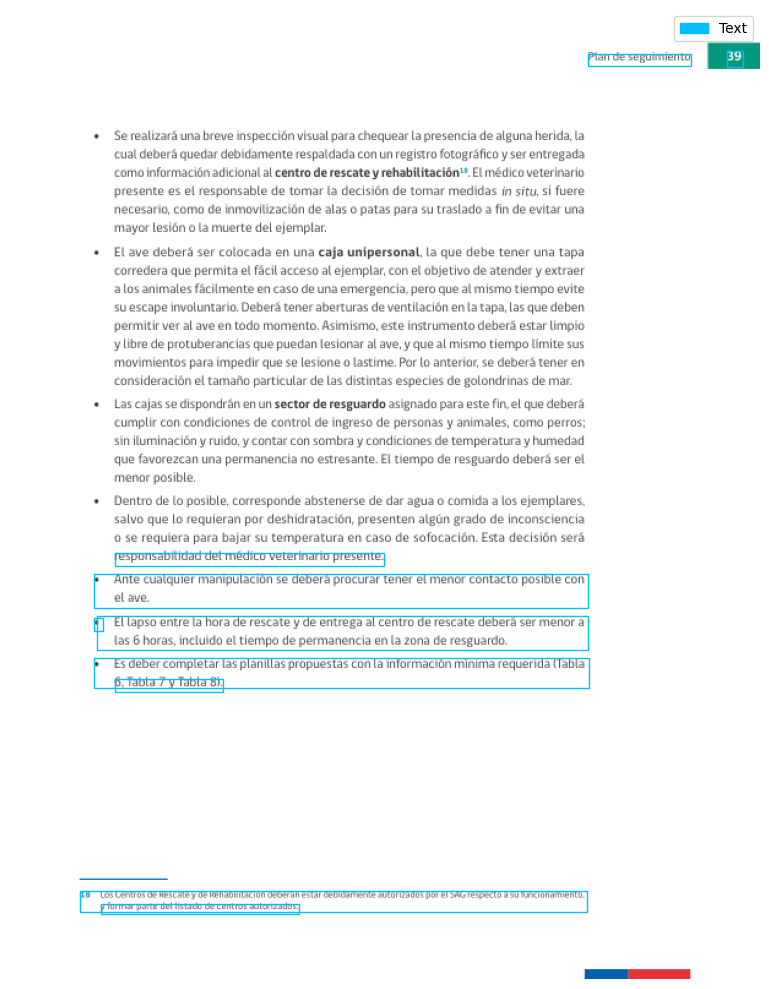

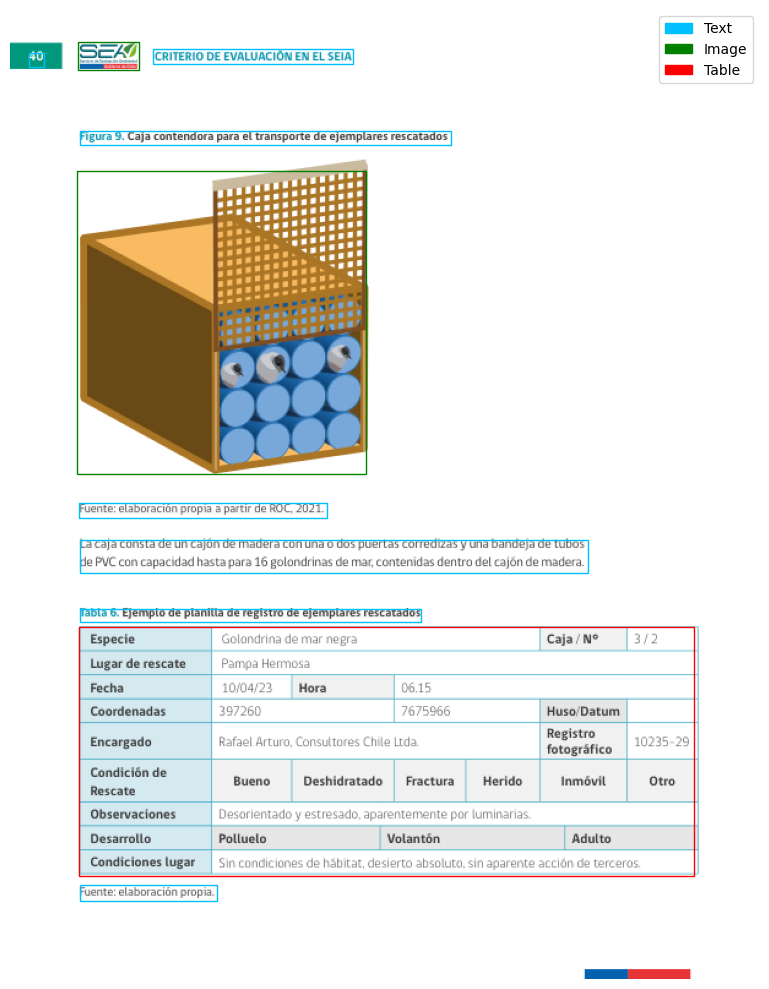

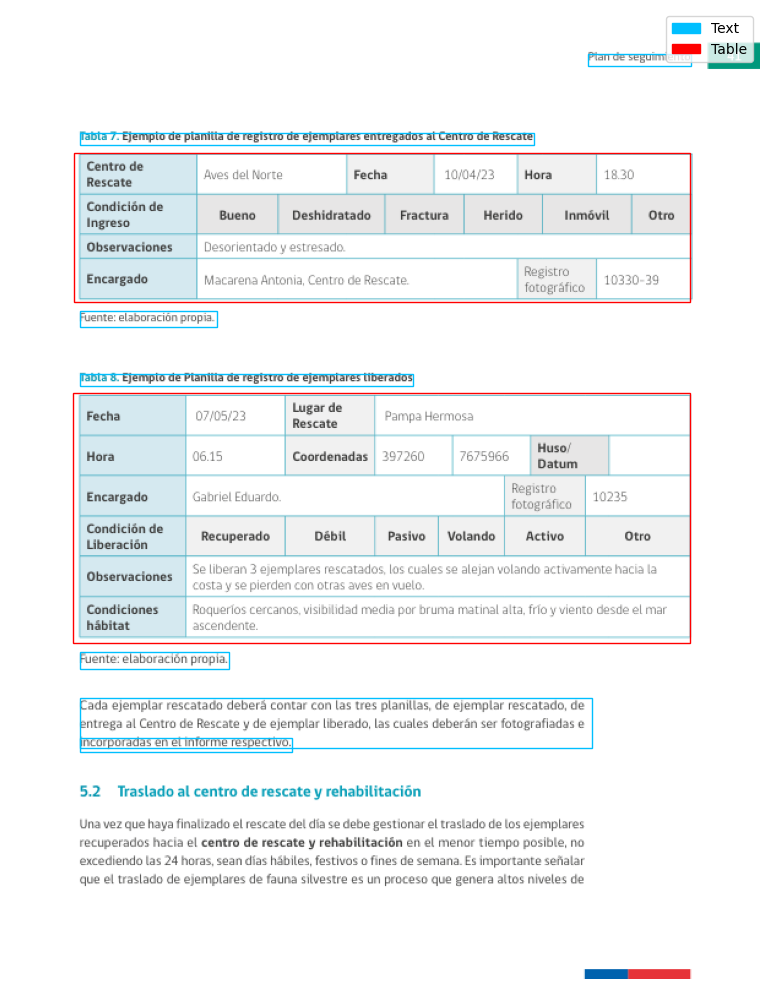

In [49]:
display_chunk_pages(chunks[29])

In [42]:
len(chunks)

35